In [1]:
import pandas as pd
import numpy as np
import logging
import tqdm 
import time
from pathlib import Path

import torch
from transformers import BartForSequenceClassification, BartTokenizer, BartConfig
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# internal libraries
from ressources import target_to_label

# set a seed value
torch.manual_seed(555)

logging.basicConfig(level=logging.WARNING)

C:\Users\ready\anaconda3\envs\Hackathon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
results_dir = Path("results")
results_dir.mkdir(exist_ok=True)
now = time.time()

label_to_target = {v: k for k, v in target_to_label.items()}

with open(results_dir / Path(f"zs-nli-{now}.csv"), "w") as f:
    f.write(
        "text,target1,target2,exec_time,"
        + ",".join([k for k in target_to_label.keys()])
        + "\n"
    )


In [3]:
targets = [k for k in target_to_label.keys()]
targets.append("0")

In [4]:
config = BartConfig.from_pretrained("valhalla/distilbart-mnli-12-9")
tokenizer = BartTokenizer.from_pretrained("valhalla/distilbart-mnli-12-9")
model = BartForSequenceClassification.from_pretrained("valhalla/distilbart-mnli-12-9")

In [5]:
#data = pd.read_csv("osdg-data.csv")

#df = data[(data["sdg"] == 12) & (data["label_osdg"] == "accepted")]

#text = df["text"].iloc[0]
#print(text)

In [6]:
def predict(premise, hypothesis):
    # run through model pre-trained on MNLI
    input_ids = tokenizer.encode(premise, hypothesis, truncation=True, return_tensors="pt")
    logits = model(input_ids)[0]

    # we throw away "neutral" (dim 1) and take the probability of
    # "entailment" (2) as the probability of the label being true
    entail_contradiction_logits = logits[:, [0, 2]]

    probs = entail_contradiction_logits.softmax(dim=1)
    true_prob = probs[:, 1].item() * 100
    #logging.info(f"Probability that '{hypothesis}' is true: {true_prob:0.2f}%")

    return true_prob

In [7]:
labels = list(target_to_label.values())
# data
df = pd.read_csv("data/afd_targets_odd_12_15_16.csv")

#df true
df_true = pd.read_csv("data/afd_targets_odd_12_15_16.csv")


y_true = []
y_pred = []

pbar = tqdm.tqdm(150)

for index, row in df_true.iterrows() : # text

    results = {**{"text": [], "exec_time": []}, **{k: [] for k in target_to_label.keys()}}

    start_time = time.time()
    results["text"].append(row['text'])

    target_max = None
    maximum = -1
    for label in labels:
        # Build hypothesis
        hypothesis = "The context is " + label

        # Run prediction
        true_prob = predict(row['text'], hypothesis)

        target = label_to_target[label]
        results[target].append(true_prob)
        
        if true_prob >= maximum :
            maximum = true_prob
            target_max = target

    total_time = time.time() - start_time
    #logging.info(f"Total prediction time : {total_time:0.2f}s")

    results["exec_time"].append(total_time)
    
    # add maximum and true label
    y_pred.append(target_max)
    y_true.append(df_true.iloc[index]['target1'])
    
    with open(results_dir / Path(f"zs-nli-{now}.csv"), "a") as f:
        for i in range(len(results["exec_time"])):
            text = results["text"][i]
            exec_time = results["exec_time"][i]
            new_line = (
                f'"{text}",'
                + ",".join([f"{v[i]:.2f}" for k, v in results.items() if k != "text"])
                + "\n"
            )
            f.write(new_line)

    del results
    pbar.update(1)

150it [29:00, 14.30s/it]

In [8]:
print(y_true,y_pred)

['0', '0', '15.1', '15.3', '15.5', '15.6', '15.5', '15.2', '0', '15.1', '15.1', '15.1', '15.6', '0', '15.1', '0', '15.2', '15.1', '0', '15.6', '15.1', '0', '15.1', '15.2', '15.3', '15.1', '0', '15.1', '15.5', '15.1', '15.1', '15.5', '15.2', '15.1', '15.5', '15.1', '0', '0', '15.6', '15.1', '0', '0', '15.5', '15.3', '15.2', '15.3', '0', '15.5', '15.2', '0', '12.4', '12.4', '12.5', '0', '12.4', '12.4', '12.5', '12.4', '12.4', '12.5', '12.5', '12.5', '12.4', '12.5', '12.5', '0', '12.7', '12.4', '12.4', '0', '12.a', '12.4', '12.4', '12.4', '12.4', '12.4', '12.4', '12.5', '12.4', '12.4', '12.4', '12.4', '12.4', '0', '12.4', '12.4', '12.5', '12.4', '0', '12.3', '12.4', '12.2', '12.5', '12.3', '12.5', '12.4', '12.4', '12.a', '0', '12.4', '16.10', '16.6', '16.5', '0', '16.6', '16.6', '16.1', '16.3', '16.b', '16.6', '16.6', '16.7', '16.1', '16.1', '16.6', '0', '16.7', '16.5', '0', '16.6', '16.5', '16.7', '16.1', '0', '0', '16.5', '16.7', '16.a', '16.5', '16.6', '16.a', '16.5', '16.7', '16.7', '

C:\Users\ready\anaconda3\envs\Hackathon\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ready\anaconda3\envs\Hackathon\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ready\anaconda3\envs\Hackathon\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ready\ana

              precision    recall  f1-score   support

        12.1       0.00      0.00      0.00         0
        12.2       0.00      0.00      0.00         1
        12.3       0.00      0.00      0.00         2
        12.4       0.00      0.00      0.00        27
        12.5       0.43      0.27      0.33        11
        12.6       0.00      0.00      0.00         0
        12.7       0.00      0.00      0.00         1
        12.8       0.00      0.00      0.00         0
        12.a       0.00      0.00      0.00         2
        12.b       0.00      0.00      0.00         0
        12.c       0.00      0.00      0.00         0
        15.1       0.17      0.13      0.15        15
        15.2       1.00      0.17      0.29         6
        15.3       0.00      0.00      0.00         4
        15.4       0.00      0.00      0.00         0
        15.5       0.15      0.29      0.20         7
        15.6       0.00      0.00      0.00         4
        15.7       0.00    

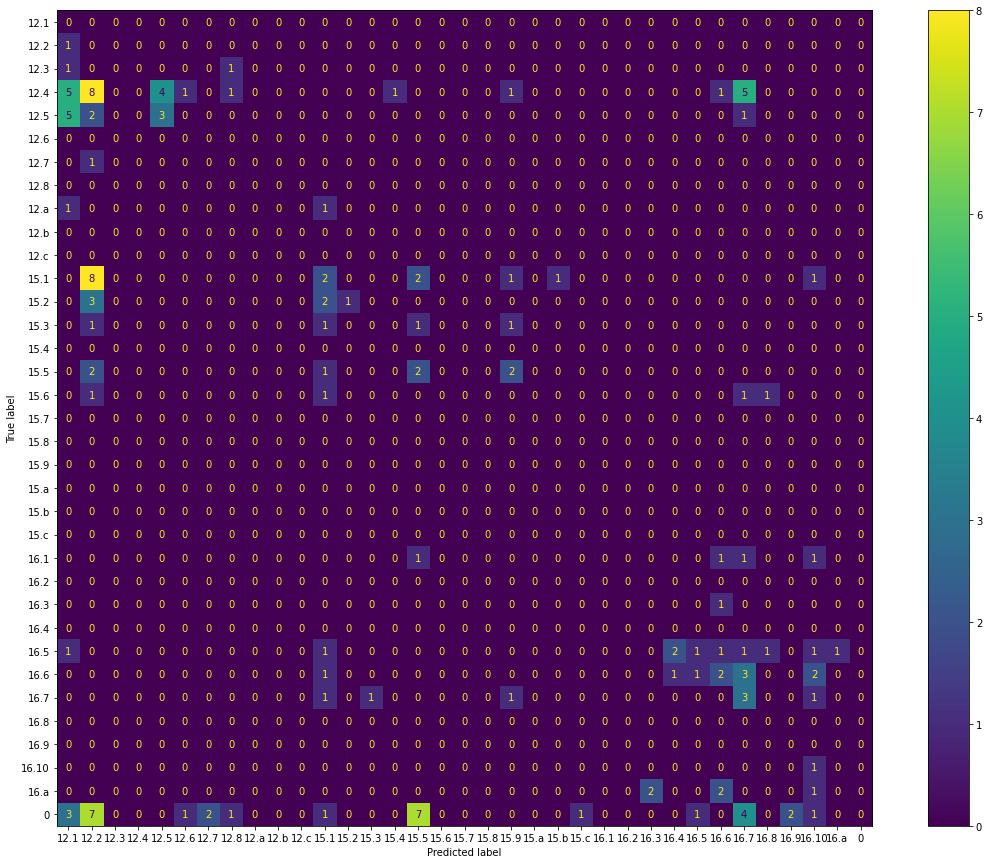

In [9]:
print(classification_report(y_true, y_pred, labels=targets))
 
fig, ax = plt.subplots(figsize=(20,15))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, labels=targets, ax=ax)